# Analysis on Grouped HealthCodes Gait Features

This notebook explores the gait features of grouped healthcodes coming from the active tests of Sage Bionetowrks mPower App and controls from ElevateMS study cohort. The goal of this notebook is to further understand how gait features on PD and non-PD varies accross different demographics cohort. The pipeline of how we retrieve this feature sets is documented on a repostitory of this github repository: <b>http://github.com/arytontediarjo/mpower-gait-analysis</b>. 

### Table of Contents:

##### 1. Introduction

##### 2. Raw Probability Distribution Visualization of Treatment and Control Groups

##### 3. Baseline Prediction and Embedded Feature Importances

##### 4. EDA on Important Features

## 1. Introduction

#### Explaining the Features:

So in our gait analysis, all the features will be annotated as following:
    
     (aggregation_type)_(axis)_(name of feature) 
    
Several aggregation types are chosen based on several aspects:
    
    - `median`: Due to its insensitivy to outliers in getting the general overview of the features
    - `amax`: For capturing the "ON" phase of PD
    - `iqr`: For capturing a more balanced difference between "ON" and "OFF" phase of a PD
    
#### Feature Descriptions:

- <b> Cadence </b>: Number of heel strikes per seconds
- <b>Energy Freeze Index</b>: Power in freeze band (high frequency band)/ Power in locomotor band (lower frequency band) 
- <b>Locomotor Freeze Index</b>: Power in freeze band (high frequency band) + Power in locomotor band (lower frequency band)
- <b>Average step/stride duration</b>: The average time duration between each step/stride
- <b>Std of step/Stride duration</b>: The standard deviation of time duration between each step/stride
- <b>Speed of gait</b>: gait speed from the energies of the approximation coefficients of wavelet functions
- <b>Step/stride regularity</b>: consistency of step/stride on a given x, y or z axis
- <b>Symmetry</b>: difference between step and stride regularity.
- <b>Rotation omega</b>: speed of turning (if it exists)    



#### Matched Users:

In our cohort anaysis, we will be using a matched healthcodes that has been subsampled to have no associations towards how likely they are to be PD or non-PD based on their own metadata (more information is addressed on the repo). Thus, by breaking the association of the metadata, our future models would not be dependent on what kind of metadata that the users might have. 

Link to matching documentation: https://github.com/arytontediarjo/mpower-gait-analysis/notebooks/matching_metadata.pdf

### Library Imports

In [1]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

#### Global Variables

In [2]:
WALKING_GROUPED_FEATURES = "syn21678699"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



#### Helper Function

In [3]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data

def visualize_feature_importances(X_train, *models):
    for model in models:
        try:
            features = model.best_estimator_["classifier"].feature_importances_
        except:
            features = model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X_train.columns[model.best_estimator_["feature_selection"].get_support()]))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()

#### Get Gait Feature and Matched Demographic Datasets

In [4]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)


data = data[[feat for feat in data.columns if ("filepath" not in feat) 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]


# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(demographic[["healthCode"]], data, on = "healthCode", how = "inner")

# set healthcode as index
data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

## 2. Baseline Model using Performance Random Forests

- Null values are imputed by median
- Random Forest with 1000 subtrees are used for model fitting
- Check feature importances based on Random Forest Model

In [5]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

In [6]:
# Create raw model with 1000 estimators
model = RandomForestClassifier(bootstrap = True,
                               n_estimators = 100,
                              random_state = 100)

# A simple median imputation on feature sets
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')


# split train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.25,
                                                   random_state = 100)
imp_median.fit(X_train)
X_train = imp_median.transform(X_train)
model.fit(X_train, y_train)

X_test = imp_median.transform(X_test)
y_pred = model.predict(X_test)

#### Base RF-Model Performance

In [7]:
get_results_dataframe(X_test, y_test, model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,RandomForestClassifier,NaN,NaN,0.558219,15.244856,0.529412


#### Classification Report

In [8]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.62      0.58        73
           1       0.56      0.50      0.53        72

    accuracy                           0.56       145
   macro avg       0.56      0.56      0.56       145
weighted avg       0.56      0.56      0.56       145



#### Confusion Matrix

In [9]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             index = ["predicted: 0", "predicted: 1"], 
             columns = ["true: 0", "true: 1"])

,true: 0,true: 1
predicted: 0,45,28
predicted: 1,36,36


It seems that our base model using random forest has some capability of recognizing users that are PD and those who are not from our studies in mPowerV1, mPowerV2 and ElevateMS.

#### Class Prediction Probability Distribution 

In [10]:
# get probability dataframe
proba = pd.DataFrame({"probability": model.predict_proba(X_test)[:,1], })
proba["class"] = y_test.reset_index(drop = True)

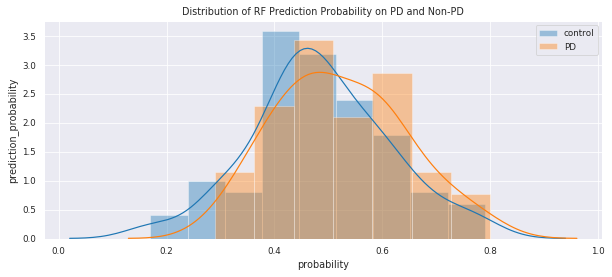

In [20]:
# plot probability distribution
plt.figure(figsize = (10,4))
sns.distplot(proba["probability"][proba["class"] == 0], label = "control")
sns.distplot(proba["probability"][proba["class"] == 1], label = "PD")
plt.legend()
plt.ylabel("prediction_probability")
plt.title("Distribution of RF Prediction Probability on PD and Non-PD")
plt.show()

The current base model shows that the model is not unable to separate case between controls, however this does not stop us from knowing which of the features might be insightful for analysis.

#### Random Forest Embedded Feature Importances (Top 20)

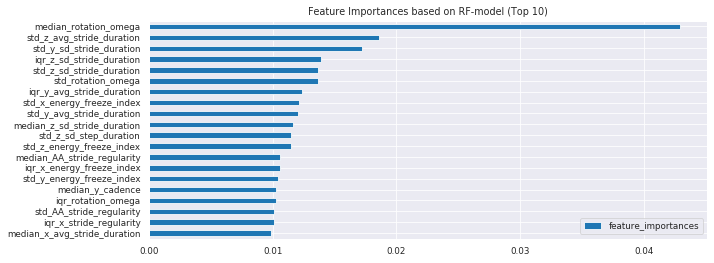

In [12]:
pd.DataFrame(data = model.feature_importances_, index = train.columns)\
.sort_values(0, ascending = True)\
.tail(20)\
.rename({0:"feature_importances"}, axis = 1)\
.plot(kind = "barh", figsize = (10,4))
plt.title("Feature Importances based on RF-model (Top 10)")
plt.show()

- Rotation omega is shown to be very indicative on differentiating PD vs non-PD as features related to rotation seems to be on top of the list on all kinds of aggregation types
- Most of the features have strong signal in y-axis, which might be caused of the phone oriented in the pocket, which is sensitive towards capturing signals in the y-axis of the phones
- Deviation in aggregation of each healthcode can be predictive as well. This is because user that has PD can have episodes that happened occasionally

### 4. EDAs on High Scoring Features

In [13]:
data["age_group"] = pd.qcut(data["age"], q = 4)

#### a. Median Rotation Speed over Older Age

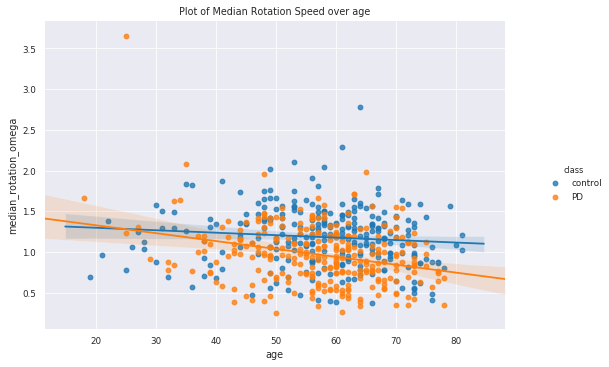

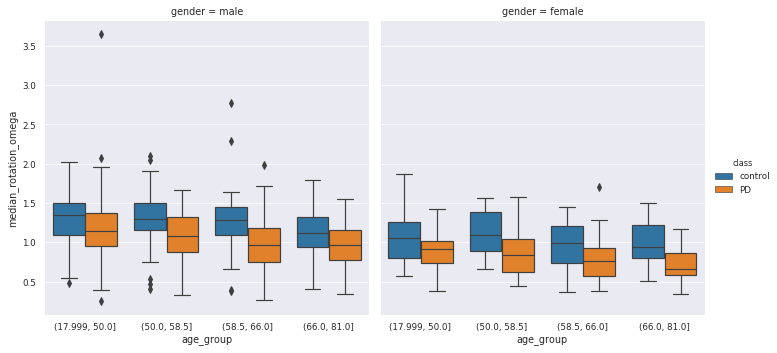

In [14]:
rotation = data[[feat for feat in data.columns if ("rotation_omega" in feat) or 
                       ("age" in feat) or ("gender" in feat) or ("class" in feat)]]
rotation  = rotation[rotation["median_rotation_omega"] > 0]


plot = sns.lmplot(y = "median_rotation_omega", x = "age", 
                  data = rotation, 
                  hue = "class", hue_order = ["control", "PD"])
plot.fig.set_size_inches(9,5)
plt.title("Plot of Median Rotation Speed over age")


sns.catplot(y = "median_rotation_omega", x = "age_group", 
           data = rotation, col = "gender",
            hue = "class",
            hue_order = ["control", "PD"],
           kind = "box", 
           height = 5)
plt.show()

- Difference between case vs control is notable in the box plot of median rotation speed, 
- As age is age-matched, impact of age is not apparent to the features, noted from the box plot being roughly similar on every age group

### b. Increase in Average and Deviation of Stride-Stride Duration

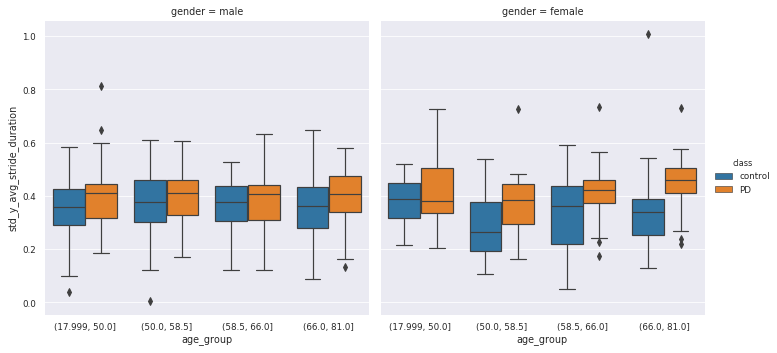

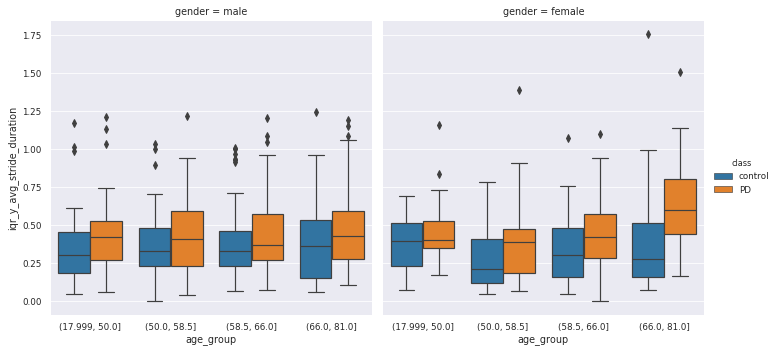

In [15]:
sns.catplot(y = "std_y_avg_stride_duration", x = "age_group", 
           data = data[["age_group", "std_y_avg_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order = ["control", "PD"],
           kind = "box", height = 5)



sns.catplot(y = "iqr_y_avg_stride_duration", x = "age_group", 
           data = data[["age_group", "iqr_y_avg_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",hue_order = ["control", "PD"],
           kind = "box", height = 5)

plt.show()

- Despite imbalance on distribution, we can see that PD has higher IQR of strides
- This can happen to festination period. where PD will freeze, unable to move, and accelerate involuntarily. Therefore there might be some cases where their duration from one stride to another will be really fast and really low whenever they are shuffling.

### c. Median Stride Regularity

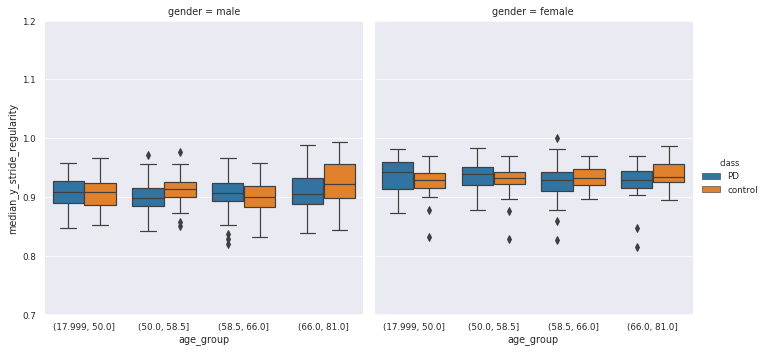

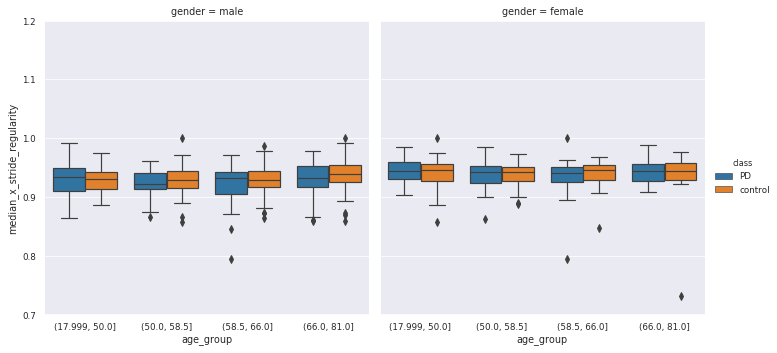

In [16]:
sns.catplot(y = "median_y_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_y_stride_regularity", "class", "gender"]].dropna(), 
            hue = "class", col = "gender",
           kind = "box", height = 5)
plt.ylim(0.7,1.2)
plt.show()

sns.catplot(y = "median_x_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_x_stride_regularity", "class", "gender"]].dropna(), 
            hue = "class", col = "gender",
           kind = "box", height = 5)
plt.ylim(0.7,1.2)
plt.show()


Median stride regularity on the different demographics seemed to have a trend as well as we can see that the median stride regularity, which measures how consistent the stride pattern is on the given axis seems to decrase as the age group increases. 

### d. Symmetry Interquartile Range on Different Demographics

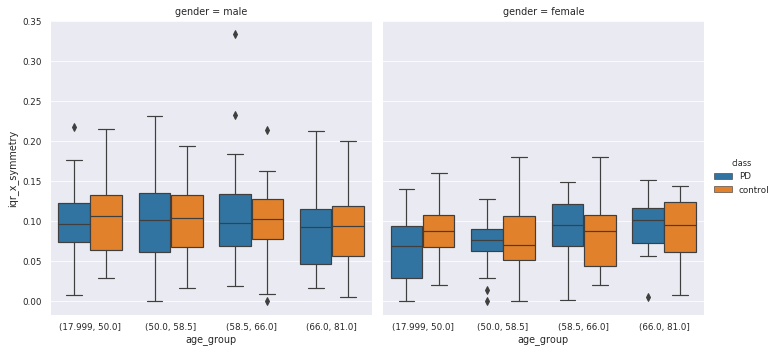

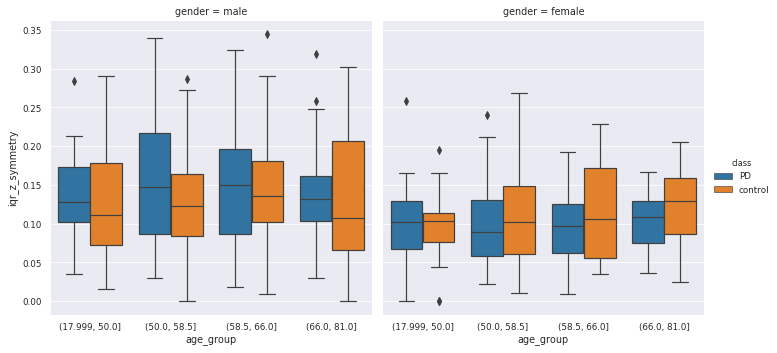

In [17]:
cat = sns.catplot(y = "iqr_x_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_x_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)

cat = sns.catplot(y = "iqr_z_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_z_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)

- Despite looking like a strong feature, symmetry is not consistent between the cohort comparisons

### e. Freeze Index

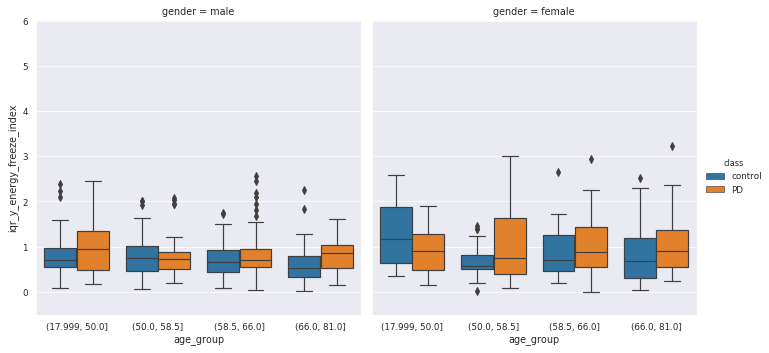

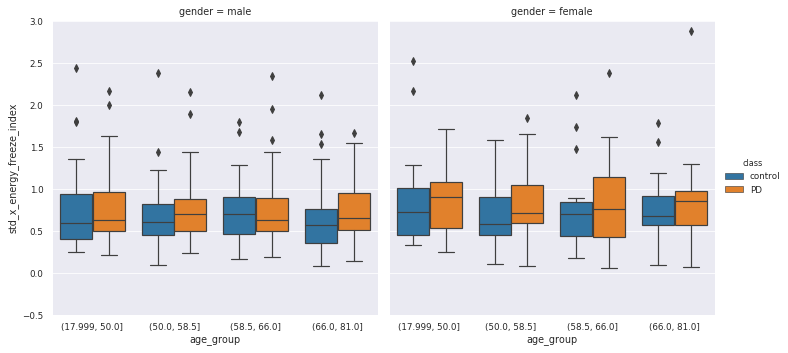

In [18]:
sns.catplot(y = "iqr_y_energy_freeze_index", x = "age_group", 
           data = data[["age_group", "iqr_y_energy_freeze_index", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order =["control", "PD"],
           kind = "box", height = 5)
plt.ylim(-0.5,6)
plt.show()

sns.catplot(y = "std_x_energy_freeze_index", x = "age_group", 
           data = data[["age_group", "std_x_energy_freeze_index", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order =["control", "PD"],
           kind = "box", height = 5)
plt.ylim(-0.5,3)
plt.show()

- In terms of freeze index, we can see that PD generally has higher deviation, as their freeze index can change rapidly, due to festination

### Assessing Correlations between Gait Features

As we are using features that is based on aggregation, it is common to face highly correlated features.

In [19]:
print("Top Absolute Correlations")
get_top_abs_correlations(data[feat_cols], 20)

Top Absolute Correlations


median_AA_loco_freeze_index  median_AA_speed_of_gait         0.951497
std_AA_step_regularity       std_AA_stride_regularity        0.937679
iqr_x_energy_freeze_index    std_x_energy_freeze_index       0.931412
std_x_step_regularity        std_x_stride_regularity         0.916846
iqr_AA_speed_of_gait         std_AA_speed_of_gait            0.910365
iqr_AA_step_regularity       iqr_AA_stride_regularity        0.903543
median_AA_step_regularity    median_AA_stride_regularity     0.903465
median_z_avg_step_duration   median_z_avg_stride_duration    0.900375
median_x_avg_step_duration   median_x_avg_stride_duration    0.894610
median_AA_loco_freeze_index  median_x_loco_freeze_index      0.884078
iqr_AA_loco_freeze_index     iqr_AA_speed_of_gait            0.883310
iqr_z_loco_freeze_index      std_z_loco_freeze_index         0.883163
median_AA_loco_freeze_index  median_y_loco_freeze_index      0.882065
iqr_y_energy_freeze_index    std_y_energy_freeze_index       0.865910
iqr_AA_loco_freeze_i

## Results:

- The results of our analysis shows that the PDKit features are able to capture signals on users that is PD or non-PD 
- Rotation speed are a very strong feature as it is able to score really high on both the median and max aggregation, and as it increases in age group, it is apparent that the rotation speed for non-PD is not decreasing as drastically as the ones that has PD
- Average and deviation of stride-stride duration seems to increase over increasing age group, especially on the PD group, which could happen due to more erratic pattern in their gait movement. 
- Regularity in an axis (consistency of movement direction in an axis) seems to decrease more drastically in PD group when compared to the non-PD
- Interquartile ranges are an interesting feature to capture due to its capability to capture festination phase of PD, as an example is on the interquartile of z-symmetry, which is one of the strongest feature for prediction. 
- Median freeze index also proves to be a feature that can be essential towards prediction as it is able to capture signals in increasing age groups.

From all the features above, we can see that the male groups seems to have more monotonic relationship as the age group increases, however we could not say the same to the female group as we lack female that exists in the last age subgroups based on the subsampling that we had done prior to this analysis. 

### Future Ideas:
- Try out feature combination for reducing redundant features
- Try other subsamples of metadata
- Gather more data samples from Android